In [1]:
# Load WDS astrometry:
import pandas as pd
wds = pd.read_table('HIP67506AB-WDS_astr.txt',delim_whitespace=True, comment='#',
                    names = ['date','pa','paerr','sep','seperr','mag1','mag1err','mag2','mag2err','cent-WL',
                            '2','3','4','5','6','7'])
wds

,date,pa,paerr,sep,seperr,mag1,mag1err,mag2,mag2err,cent-WL,2,3,4,5,6,7
0,1991.250,323.300,.,9.190,.,10.932,0.032,12.709,0.163,511,222,0.3,1,HIP1997a,Hh,5
1,1991.430,323.400,.,9.190,.,10.779,0.056,12.709,0.163,530,100,0.3,1,TYC2002,Ht,6
2,1998.482,324.600,0.1,9.230,0.001,10.730,0.03,11.980,0.43,609,70f,0.2,4,UC_2013b,Eu,7
3,1999.400,324.300,.,9.280,.,9.649,0.023,10.265,0.026,1256,245,1.3,1,TMA2003,E2,7
4,2010.500,326.000,0.9,9.330,0.15,9.189,0.025,9.475,0.023,3350,.,0.4,1,WIS2012,Hw,7
5,2015.000,326.899,.,9.377,.,10.639,.,11.872,.,673,440,1.0,1,Kpp2018m,Hg,7


In [2]:
# Get Gaia DR3 astrometry:
def to_polar(RAa,RAb,Deca,Decb):
    ''' Converts RA/Dec [deg] of two binary components into separation and position angle of B relative 
        to A [mas, deg]
    '''
    import numpy as np
    import astropy.units as u
    dRA = (RAb - RAa) * np.cos(np.radians(np.mean([Deca,Decb])))
    dRA = (dRA*u.deg).to(u.mas)
    dDec = (Decb - Deca)
    dDec = (dDec*u.deg).to(u.mas)
    r = np.sqrt( (dRA ** 2) + (dDec ** 2) )
    p = (np.degrees( np.arctan2(dDec.value,-dRA.value) ) + 270.) % 360.
    p = p*u.deg
    return r, p

def get_seppa(source_id1,source_id2, catalog = 'gaiaedr3.gaia_source'):
    '''Use Gaia DR2 source ids to return separation in arcsec and 
    the position angle between two sources in degrees
    '''
    import warnings
    warnings.filterwarnings("ignore")
    import numpy as np
    from astroquery.gaia import Gaia

    mas_to_deg = 1./3600000.
    
    job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(source_id1))
    j = job.get_results()

    job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(source_id2))
    k = job.get_results()

    RAa, RAaerr = j[0]['ra'], j[0]['ra_error']*mas_to_deg
    RAb, RAberr = k[0]['ra'], k[0]['ra_error']*mas_to_deg
    Deca, Decaerr = j[0]['dec'], j[0]['dec_error']*mas_to_deg
    Decb, Decberr = k[0]['dec'], k[0]['dec_error']*mas_to_deg

    raa_array = np.random.normal(RAa, RAaerr, 10000)
    rab_array = np.random.normal(RAb, RAberr, 10000)
    deca_array = np.random.normal(Deca, Decaerr, 10000)
    decb_array = np.random.normal(Decb, Decberr, 10000)
    rho_array,pa_array = to_polar(raa_array,rab_array,deca_array,decb_array)
    pa,paerr = np.mean(pa_array).value,np.std(pa_array).value
    rho, rhoerr  = np.mean(rho_array).value, np.std(rho_array).value
    return rho/1000,rhoerr/1000, pa, paerr

A_sourceid = 6109011780753115776
B_sourceid = 6109011742094383744
r = get_seppa(A_sourceid, B_sourceid, catalog = 'gaiadr3.gaia_source')
rr = pd.Series(data={'date':2016.0, 'pa':r[2], 'paerr':r[3], 'sep':r[0], 'seperr':r[1]})
wds = wds.append(rr, ignore_index=True)
wds

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


,date,pa,paerr,sep,seperr,mag1,mag1err,mag2,mag2err,cent-WL,2,3,4,5,6,7
0,1991.250,323.300000,.,9.190000,.,10.932,0.032,12.709,0.163,511.0,222,0.3,1.0,HIP1997a,Hh,5.0
1,1991.430,323.400000,.,9.190000,.,10.779,0.056,12.709,0.163,530.0,100,0.3,1.0,TYC2002,Ht,6.0
2,1998.482,324.600000,0.1,9.230000,0.001,10.730,0.03,11.980,0.43,609.0,70f,0.2,4.0,UC_2013b,Eu,7.0
3,1999.400,324.300000,.,9.280000,.,9.649,0.023,10.265,0.026,1256.0,245,1.3,1.0,TMA2003,E2,7.0
4,2010.500,326.000000,0.9,9.330000,0.15,9.189,0.025,9.475,0.023,3350.0,.,0.4,1.0,WIS2012,Hw,7.0
5,2015.000,326.899000,.,9.377000,.,10.639,.,11.872,.,673.0,440,1.0,1.0,Kpp2018m,Hg,7.0
6,2016.000,327.036249,0.000171508,9.385933,3.29461e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Get Proper motion: from Gaia
from astroquery.gaia import Gaia
deg_to_mas = 3600000.
mas_to_deg = 1./3600000.

catalog = 'gaiadr3.gaia_source'
job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(A_sourceid))
j = job.get_results()

pmRA = j['pmra'][0] #mas/yr
pmDec = j['pmdec'][0]
bkgd_star_vel_vector = np.sqrt(pmRA**2+pmDec**2)

# Get arrays from WDS table:
sep = wds['sep']
pa = np.radians(wds['pa'])
obs_RAs = (sep * np.cos(pa))*u.arcsec.to(u.mas) * np.cos(np.radians(j['dec']))
obs_Decs = -(sep * np.sin(pa))*u.arcsec.to(u.mas)
obsdate = wds['date']


# Make common-proper-motion plot:

In [ ]:
def ecliptic_to_equatorial(lon, lat):
    ''' Convert array from ecliptic to equatorial coordinates using astropy's SkyCoord object
        Inputs:
            lon, lat [deg] (array): ecliptic longitude (lambda) and ecliptic latitude (beta)
        Returns:
            newRA, newDec [deg] (array): array points in equatorial RA/Dec coordinates
    '''
    from astropy.coordinates import SkyCoord
    import numpy as np
    # Compute ecliptic motion to equatorial motion:
    newRA, newDec = np.zeros(len(lon)),np.zeros(len(lon))
    for i in range(len(lon)):
        obj2 = SkyCoord(lon = lon[i],\
                    lat = lat[i], \
                    frame='geocentrictrueecliptic', unit='deg') 
        obj2 = obj2.transform_to('icrs')
        newRA[i] = obj2.ra.deg
        newDec[i] = obj2.dec.deg
    return newRA,newDec

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.time import Time
from astropy.coordinates import SkyCoord, GeocentricTrueEcliptic
from myastrotools.tools import ecliptic_to_equatorial
from cycler import cycler


# Select a Reference epoch:
ref_index = 1

# Get reference epoch RA/Dec
ref_RA = obs_RAs[ref_index]
ref_Dec = obs_Decs[ref_index]

# Specify the reference time:
ref_date = Time(obsdate[ref_index],format='decimalyear',scale='utc')
# Select a time interval for background track to plot.  
# Indicies are reference epoch - time_interval[0], reference epoch + time_interval[1] in years
time_interval=[4,30]

ref_RA_offset = ref_RA
ref_Dec_offset = ref_Dec

# Set some plotting parameters:
marker_size = [600,300]
label_offset = [100,-15]
labelsize = 25

plt_style = 'magrathea_bold'

# Color cycler:
n = 8
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.jet(np.linspace(0,1,n)))
colors = plt.cm.gnuplot(np.linspace(0,1,n))
labels=np.round(wds['date'],decimals=2)

n_times = 800
xlabel = r'$\Delta$ RA (mas)'
ylabel = r'$\Delta$ Dec (mas)'
marker = ['d','o']
fontsize = 20
tick_labelsize = 25
alpha=0.5
figsize = (10,8)
write_to_file = False
output_name = 'cpm.pdf'
form = 'pdf'
plt_xlim=None
plt_ylim=None

# Get A and B gaia info:
catalog = 'gaiadr3.gaia_source'
job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(A_sourceid))
j = job.get_results()

job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(B_sourceid))
k = job.get_results()

RA, RAerr, Dec, Decerr = j['ra'][0],j['ra_error'][0]*mas_to_deg,j['dec'][0],j['dec_error'][0]*mas_to_deg
pmRA,pmRAerr,pmDec,pmDecerr = j['pmra'][0],j['pmra_error'][0],j['pmdec'][0],j['pmdec_error'][0]
parallax, parallax_error = j['parallax'][0],j['parallax_error'][0]

# We are plotting the motion of non-moving background stars if we follow the foreground star, so
# we need to reverse the direction of A's proper motion:
pmRA = -pmRA
pmDec = -pmDec

RA2, RA2err, Dec2, Dec2err = k['ra'][0],k['ra_error'][0]*mas_to_deg,k['dec'][0],k['dec_error'][0]*mas_to_deg
pmRA2,pmRA2err,pmDec2,pmDec2err = k['pmra'][0],k['pmra_error'][0],k['pmdec'][0],k['pmdec_error'][0]
parallax2, parallax_error2 = k['parallax'][0],k['parallax_error'][0]


plt.style.use(plt_style)
deg_to_mas = 3600000.
mas_to_deg = 1./3600000.


############### Compute A's track: ###################
# Define a time span around reference date:
delta_time = np.linspace(-time_interval[0], time_interval[1], n_times)*u.yr
times = ref_date + delta_time

# Compute change in RA/Dec during time interval due to proper motion only:
dRA, dDec = (pmRA)*(delta_time.value), (pmDec)*(delta_time.value)

# Compute motion in the ecliptic coords due to parallactic motion:
# Make a sky coord object in RA/Dec:
obj = SkyCoord(ra = RA, dec = Dec, frame='icrs', unit='deg'#, obstime = 'J2015.5'
              ) 
# Convert to ecliptic lon/lat:
gteframe = GeocentricTrueEcliptic()
obj_ecl = obj.transform_to(gteframe)

# Angle array during a year:
theta = (delta_time.value%1)*2*np.pi
#Parallel to ecliptic:
x = parallax*np.sin(theta)  
#Perp to ecliptic
y = parallax*np.sin(obj_ecl.lat.rad)*np.cos(theta)

# Compute ecliptic motion to equatorial motion:
new_RA, new_Dec = ecliptic_to_equatorial(obj_ecl.lon.deg+x*mas_to_deg, \
                                       obj_ecl.lat.deg+y*mas_to_deg)
from astropy.coordinates import SkyCoord
maxecl_lon = np.max(obj_ecl.lon.deg+x*mas_to_deg)
maxecl_lat = np.max(obj_ecl.lat.deg+y*mas_to_deg)
obj2 = SkyCoord(lon = maxecl_lon,\
                    lat = maxecl_lat, \
                    frame='geocentrictrueecliptic', unit='deg')
obj2 = obj2.transform_to('icrs')

# Compute change in RA/Dec for each time point in mas:
delta_RA, delta_Dec = (new_RA-RA)*deg_to_mas,(new_Dec-Dec)*deg_to_mas

#Put it together:
dRA_total = delta_RA * np.cos(np.radians(j['dec']))[0] + dRA + ref_RA_offset
dDec_total = delta_Dec + dDec + ref_Dec_offset

############# Compute prediction: #############
### Where the object would have been observed were it a background object

# Compute how far into each year the observation occured:
pred_time_delta = (obsdate - np.floor(obsdate))
pred_theta = (pred_time_delta)*2*np.pi

# Compute ecliptic motion:
pred_x = parallax*np.sin(pred_theta)  #Parallel to ecliptic
pred_y = parallax*np.sin(obj_ecl.lat.rad)*np.cos(pred_theta)  #Perp to ecliptic

# Convert to RA/Dec:
pred_new_RA, pred_new_Dec = ecliptic_to_equatorial(obj_ecl.lon.deg+pred_x*mas_to_deg, \
                                       obj_ecl.lat.deg+pred_y*mas_to_deg)
pred_delta_RA, pred_delta_Dec = (pred_new_RA-RA)*deg_to_mas,(pred_new_Dec-Dec)*deg_to_mas

# Compute location due to proper motion:
pred_dRA, pred_dDec = (pmRA)*(obsdate-ref_date.value), (pmDec)*(obsdate-ref_date.value)

# Put it together:
pred_dRA_total = -pred_delta_RA * np.cos(np.radians(j['dec']))[0] + pred_dRA + ref_RA_offset
pred_dDec_total = -pred_delta_Dec + pred_dDec + ref_Dec_offset

############### Compute B's track: ###################
# Define a time span around reference date:
delta_time = np.linspace(-time_interval[0], time_interval[1], n_times)*u.yr
times = ref_date + delta_time

# Compute change in RA/Dec during time interval due to proper motion only:
dRA, dDec = (pmRA2)*(delta_time.value), (pmDec2)*(delta_time.value)

# Compute motion in the ecliptic coords due to parallactic motion:
# Make a sky coord object in RA/Dec:
obj = SkyCoord(ra = RA2, dec = Dec2, frame='icrs', unit='deg'#, obstime = 'J2015.5'
              ) 
# Convert to ecliptic lon/lat:
gteframe = GeocentricTrueEcliptic()
obj_ecl = obj.transform_to(gteframe)

# Angle array during a year:
theta = (delta_time.value%1)*2*np.pi
#Parallel to ecliptic:
x = parallax*np.sin(theta)  
#Perp to ecliptic
y = parallax*np.sin(obj_ecl.lat.rad)*np.cos(theta)

# Compute ecliptic motion to equatorial motion:
new_RA2, new_Dec2 = ecliptic_to_equatorial(obj_ecl.lon.deg+x*mas_to_deg, \
                                       obj_ecl.lat.deg+y*mas_to_deg)
from astropy.coordinates import SkyCoord
maxecl_lon = np.max(obj_ecl.lon.deg+x*mas_to_deg)
maxecl_lat = np.max(obj_ecl.lat.deg+y*mas_to_deg)
obj2 = SkyCoord(lon = maxecl_lon,\
                    lat = maxecl_lat, \
                    frame='geocentrictrueecliptic', unit='deg')
obj2 = obj2.transform_to('icrs')

# Compute change in RA/Dec for each time point in mas:
delta_RA2, delta_Dec2 = (new_RA2-RA2)*deg_to_mas,(new_Dec2-Dec2)*deg_to_mas

i = np.shape(pred_dRA_total)[0] - 1
ref_RA_offset2 = pred_dRA_total[i]
ref_Dec_offset2 = pred_dDec_total[i]

#Put it together:
dRA_total2 = delta_RA2 * np.cos(np.radians(j['dec']))[0] + dRA + ref_RA_offset2
dDec_total2 = delta_Dec2 + dDec + ref_Dec_offset2

############# Compute prediction: #############
### Where the object would have been observed were it a background object

# Compute how far into each year the observation occured:
pred_time_delta = (obsdate - np.floor(obsdate))
pred_theta = (pred_time_delta)*2*np.pi

# Compute ecliptic motion:
pred_x2 = parallax2*np.sin(pred_theta)  #Parallel to ecliptic
pred_y2 = parallax2*np.sin(obj_ecl.lat.rad)*np.cos(pred_theta)  #Perp to ecliptic

# Convert to RA/Dec:
pred_new_RA2, pred_new_Dec2 = ecliptic_to_equatorial(obj_ecl.lon.deg+pred_x2*mas_to_deg, \
                                       obj_ecl.lat.deg+pred_y2*mas_to_deg)
pred_delta_RA2, pred_delta_Dec2 = (pred_new_RA2-RA2)*deg_to_mas,(pred_new_Dec2-Dec2)*deg_to_mas

# Compute location due to proper motion:
pred_dRA2, pred_dDec2 = (pmRA2)*(obsdate-ref_date.value), (pmDec2)*(obsdate-ref_date.value)

# Put it together:
pred_dRA_total2 = -pred_delta_RA2 * np.cos(np.radians(j['dec']))[0] + pred_dRA2 + ref_RA_offset2
pred_dDec_total2 = -pred_delta_Dec2 + pred_dDec2 + ref_Dec_offset2


#################### Draw plot: #################
plt.rcParams['ytick.labelsize'] = tick_labelsize
plt.rcParams['xtick.labelsize'] = tick_labelsize
custom_cycler = (cycler(color=colors))
fig = plt.figure(figsize = figsize)

plt.plot(dRA_total,dDec_total, zorder = 1, color='black', lw=1.5, label=r'EDR3 $\mu$+$\pi$, A')
plt.gca().set_prop_cycle(custom_cycler)

triangleoffsets_ra = [0,0,0,0,0,0,0]
triangleoffsets_dec = [0,0,0,0,0,0,0]

labeloffsets_ra = [10,75,-20,-30,-20,140,120]
labeloffsets_dec = [-60,20,-40,-20,-15,-25,20]

# Plot predicted location of B if it were non-moving bkgd star:
for i in range(len(pred_dRA)):
    if i > 1:
        plt.scatter(pred_dRA_total[i], pred_dDec_total[i], 
                    marker = marker[0], s=marker_size[0], zorder=8, linewidths=3,
                    edgecolors=colors[i], facecolors='None')
    plt.annotate(
        labels[i],
        xy=(pred_dRA_total[i], pred_dDec_total[i]), 
            xytext=(labeloffsets_ra[i], labeloffsets_dec[i]),
        textcoords='offset points', ha='right', va='bottom', fontsize=25, color=colors[i]
    )
# Plot observed position of B:
for i in range(len(obs_RAs)):
    plt.scatter(obs_RAs[i]-2.5, obs_Decs[i]+9, edgecolors="black", marker = marker[1], s=marker_size[1], \
                    alpha=alpha, zorder = 10)

# Plot line connecting predicted to observed position:
for i in range(len(obs_RAs)-1):
    plt.plot([pred_dRA_total[i]+triangleoffsets_ra[i],obs_RAs[i]-2.5],
             [pred_dDec_total[i]+triangleoffsets_dec[i], obs_Decs[i]+9],
             color='gray', ls=':', lw=3
        )
    
# Plot B's proper motion track:
plt.plot(dRA_total2,dDec_total2, zorder = 1, color='blue', lw=1.5, label='DR3 $\mu$+$\pi$, B')

i = np.shape(pred_dRA_total)[0] - 1
#plt.scatter(pred_dRA_total2[i]+triangleoffsets_ra[i], pred_dDec_total2[i]+triangleoffsets_dec[i], 
#                marker = 'x', s=marker_size[0], zorder=8, linewidths=3,
#                edgecolors=colors[i], facecolors='None')

plt.xlabel(xlabel, fontsize = 30)
plt.xticks(rotation=45)
plt.ylabel(ylabel, fontsize = 30)
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
plt.grid(ls=':')
  
plt.tight_layout()

#plt.savefig('best_best_final_plots/HIPA_CPM_with_Gaia_pm_for_B.png')
plt.show()


<IPython.core.display.Javascript object>

# Escape velocity?

In [6]:
def v_escape(r,M):
    ''' Compute the escape velocity of an object of mass M at distance r.  M and r should be
        astropy unit objects
    '''
    try:
        r = r.to(u.au)
        M = M.to(u.Msun)
    except:
        r = r*u.au
        M = M*u.Msun
    return (np.sqrt(2*c.G*(M) / (r))).decompose()

def MonteCarloIt(thing, N = 10000):
    ''' 
    Generate a random sample of size = N from a 
    Gaussian centered at thing[0] with std thing[1]
    
    Args:
        thing (tuple, flt): tuple of (value,uncertainty).  Can be either astropy units object \
            or float
        N (int): number of samples
    Returns:
        array: N random samples from a Gaussian.

    Written by Logan Pearce, 2020
    '''
    try:
        out = np.random.normal(thing[0].value,thing[1].value,N)
    except:
        out = np.random.normal(thing[0],thing[1],N)

    return out

def get_distance(source_ids, catalog = 'gaiaedr3.gaia_source'):
    '''Use Gaia DR2 source id to return the distance and error in parsecs'''
    import warnings
    warnings.filterwarnings("ignore")
    import numpy as np
    from astroquery.gaia import Gaia
    from myastrotools.tools import distance
    try:
        d,e = np.array([]),np.array([])
        for source_id in source_ids:
            job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(source_id))
            j = job.get_results()
            di,ei = distance(np.array(j['parallax']),np.array(j['parallax_error']))
            d = np.append(d,di)
            e = np.append(e,ei)
            print('For',source_id,'d=',[di,ei])
    except:
        job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(source_ids))
        j = job.get_results()
        d,e = distance(np.array(j['parallax']),np.array(j['parallax_error']))
    return d,e

In [7]:
r_arcsec = MonteCarloIt([9.38593,3e-5])
d = get_distance(A_sourceid)
r_au = r_arcsec*MonteCarloIt(d)
#r_au = [np.mean(r_au),np.std(r_au)] * u.au
M = 2*u.Msun # two G5 stars
v_esc = v_escape(r_au*u.au,M).to(u.km/u.s)
v_esc = [np.nanmean(v_esc),np.nanstd(v_esc)]
v_esc

[<Quantity 1.3062397 km / s>, <Quantity 0.00522941 km / s>]

In [9]:

# Compute observed velocity:
pmra_obs = (obs_RAs[6] - obs_RAs[0]) / (wds['date'][6] - wds['date'][0]) #mas per year
pmra_obs = (pmra_obs/1000) * MonteCarloIt(d) # au per year
pmra_obs = (pmra_obs * (u.au/u.yr)).to(u.km/u.s)

pmdec_obs = (obs_Decs[6] - obs_Decs[0]) / (wds['date'][6] - wds['date'][0]) #mas per year
pmdec_obs = (pmdec_obs/1000) * MonteCarloIt(d) # au per year
pmdec_obs = (pmdec_obs * (u.au/u.yr)).to(u.km/u.s)

vel = np.sqrt( pmra_obs**2 + pmdec_obs**2)
vel = np.mean(vel),np.std(vel)
print('Velocity and uncert:',vel)
print('Nsigma from escape vel:',(vel[0] - v_esc[0])/vel[1])

Velocity and uncert: (<Quantity 22.67970894 km / s>, <Quantity 0.12829571 km / s>)
Nsigma from escape vel: 166.59535205403824


In [10]:
# Repeat for all wds measurements and take mean:
vels = np.array([])
vels_err = np.array([])
for i in range(2,len(obs_RAs)):
    pmra_obs = (obs_RAs[i] - obs_RAs[0]) / (wds['date'][i] - wds['date'][0]) #mas per year
    pmra_obs = (pmra_obs/1000) * MonteCarloIt(d) # au per year
    pmra_obs = (pmra_obs * (u.au/u.yr)).to(u.km/u.s)

    pmdec_obs = (obs_Decs[i] - obs_Decs[0]) / (wds['date'][i] - wds['date'][0]) #mas per year
    pmdec_obs = (pmdec_obs/1000) * MonteCarloIt(d) # au per year
    pmdec_obs = (pmdec_obs * (u.au/u.yr)).to(u.km/u.s)

    vel = np.sqrt( pmra_obs**2 + pmdec_obs**2)
    vel = np.mean(vel),np.std(vel)
    vels = np.append(vels,vel[0].value)
    vels_err = np.append(vels_err,vel[1].value)

vels2 =np.array([])
for i,v in enumerate(vels):
    vels2 = np.append(vels2,MonteCarloIt([v,vels_err[i]]))
np.mean(vels2),np.std(vels2), (np.mean(vels2) - v_esc[0].value)/np.std(vels2)

(22.366775317112957, 2.6731499894267032, 7.87854617317015)

In [12]:
# what about MonteCarloing with astrometry that has errors?
sep = wds['sep']
pa = np.radians(wds['pa'])
obs_RAs = sep * np.cos(pa)
obs_Decs = sep * np.sin(pa)

seps1 = MonteCarloIt([sep[4],float(wds['seperr'][4])])
seps2 = MonteCarloIt([sep[6],float(wds['seperr'][6])])
pas1 = MonteCarloIt([pa[4],float(wds['paerr'][4])])
pas2 = MonteCarloIt([pa[6],float(wds['paerr'][6])])

obs_RAs1 = seps1 * np.cos(pas1)
obs_Decs1 = seps1 * np.sin(pas1)
obs_RAs2 = seps2 * np.cos(pas2)
obs_Decs2 = seps2 * np.sin(pas2)
obs_Decs2

array([-5.10580776, -5.10652548, -5.10597034, ..., -5.10519389,
       -5.10471536, -5.10514204])

In [13]:
# Mmmm... what about fitting a line
ii = [0,1,3,5]
wds['relRA'], wds['relDec'] = np.nan,np.nan
wds['relRAerr'], wds['relDecerr'] = np.nan,np.nan
for i in ii:
    wds['paerr'].loc[i] = 1.0
    wds['seperr'].loc[i] = 0.2
ii = [0,1,2,3,4,5,6]
for i in ii: 
    seps = MonteCarloIt([wds['sep'][i],float(wds['seperr'][i])])
    pas = MonteCarloIt([wds['pa'][i],float(wds['paerr'][i])])
    obs_RAs1 = seps * np.cos(pas)
    obs_Decs1 = seps * np.sin(pas)
    wds['relRA'].loc[i],wds['relRAerr'].loc[i],wds['relDec'].loc[i],wds['relDecerr'].loc[i] = np.mean(obs_RAs1),\
                np.std(obs_RAs1),np.mean(obs_Decs1),np.std(obs_Decs1)
    if wds['relRA'].loc[i] > 0:
        wds['relRA'].loc[i] = -wds['relRA'].loc[i]
    if wds['relDec'].loc[i] < 0:
        wds['relDec'].loc[i] = -wds['relDec'].loc[i]
wds

,date,pa,paerr,sep,seperr,mag1,mag1err,mag2,mag2err,cent-WL,2,3,4,5,6,7,relRA,relDec,relRAerr,relDecerr
0,1991.250,323.300000,1,9.190000,0.2,10.932,0.032,12.709,0.163,511.0,222,0.3,1.0,HIP1997a,Hh,5.0,-5.308043,1.564554,4.327943,5.926609
1,1991.430,323.400000,1,9.190000,0.2,10.779,0.056,12.709,0.163,530.0,100,0.3,1.0,TYC2002,Ht,6.0,-5.511503,1.001269,4.145540,5.989920
2,1998.482,324.600000,0.1,9.230000,0.001,10.730,0.03,11.980,0.43,609.0,70f,0.2,4.0,UC_2013b,Eu,7.0,-4.829615,7.811347,0.782028,0.488653
3,1999.400,324.300000,1,9.280000,0.2,9.649,0.023,10.265,0.026,1256.0,245,1.3,1.0,TMA2003,E2,7.0,-4.283344,3.675749,5.066468,5.349054
4,2010.500,326.000000,0.9,9.330000,0.15,9.189,0.025,9.475,0.023,3350.0,.,0.4,1.0,WIS2012,Hw,7.0,-4.714528,4.070734,4.763620,5.056383
5,2015.000,326.899000,1,9.377000,0.2,10.639,.,11.872,.,673.0,440,1.0,1.0,Kpp2018m,Hg,7.0,-5.568797,0.947673,4.316389,6.115342
6,2016.000,327.036249,0.000171508,9.385933,3.29461e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.936780,2.868743,0.000495,0.001538


In [21]:
from scipy.optimize import curve_fit
def line(x,m,b):
    return m*x + b
    
i = 7
vel_ra = curve_fit(line,wds['date'][0:i],wds['relRA'][0:i],sigma=wds['relRAerr'][0:i])
vel_dec = curve_fit(line,wds['date'][0:i],wds['relDec'][0:i],sigma=wds['relDecerr'][0:i])
vel = np.sqrt(vel_ra[0][0]**2 + vel_dec[0][0]**2)
vel_err = np.sqrt(vel_ra[1][0][0]**2 + vel_dec[1][0][0]**2)
vel = np.array([vel,vel_err]) #arcsec per yr

vel = MonteCarloIt(vel)
vel_auy = vel * 102 *u.au/u.yr
vel_kms = vel_auy.to(u.km/u.s)
vel_kms

<Quantity [171.04344175, 171.25442564, 170.85069236, ..., 170.22853345,
           170.7088259 , 170.38041283] km / s>

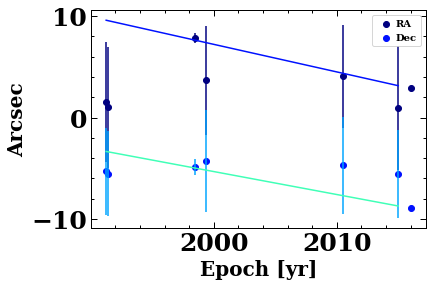

In [24]:
x = np.linspace(np.min(wds['date']),wds['date'][5],100)

%matplotlib inline
plt.scatter(wds['date'][0:i],wds['relDec'][0:i], label='RA')
plt.errorbar(wds['date'][0:i],wds['relDec'][0:i], yerr = wds['relDecerr'][0:i], ls='None')
plt.plot(x,line(x,*vel_dec[0]))
plt.scatter(wds['date'][0:i],wds['relRA'][0:i], label='Dec')
plt.errorbar(wds['date'][0:i],wds['relRA'][0:i], yerr = wds['relRAerr'][0:i], ls='None')
plt.plot(x,line(x,*vel_ra[0]))
plt.xlabel('Epoch [yr]')
plt.ylabel('Arcsec')
plt.legend()
plt.show()

# chance alignment

In [28]:
A = 6109011780753115776
B = 6109011742094383744

string = ''' SELECT * FROM gaiadr3.gaia_source WHERE source_id = ''' + str(A)
job = Gaia.launch_job(string)
gaiaA = job.get_results()

job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(B))
gaiaB = job.get_results()
gaiaA

solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,

### Astroquery limits query results to 2000 entries, so I queried through the ADQL archive interface for all objects with parallax measurements within a 1 deg radius of HIP 67560 A.

In [31]:
cone = pd.read_csv('1663103917101O-result.csv')
cone

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
0,1636148068921376768,Gaia DR3 6109011780753115776,6109011780753115776,1495045469,2016.0,207.496147,0.026335,-43.050494,0.028826,4.512717,...,0.0034,0.0225,0.0087,0.0028,0.0189,0.0047,0.0015,0.0102,MARCS,0.000505
1,1636148068921376768,Gaia DR3 6109011742094383744,6109011742094383744,1679993485,2016.0,207.494206,0.019534,-43.048306,0.021693,0.552278,...,0.5293,0.5368,0.4148,0.4119,0.4179,0.2190,0.2174,0.2207,MARCS,0.002142
2,1636148068921376768,Gaia DR3 6109011780745532416,6109011780745532416,918700187,2016.0,207.500907,0.384937,-43.052376,0.331213,1.163777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004302
3,1636148068921376768,Gaia DR3 6109014731388092672,6109014731388092672,132340053,2016.0,207.494148,0.776119,-43.044632,0.744301,0.732494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005536
4,1636148068921376768,Gaia DR3 6109014701326224128,6109014701326224128,1483593714,2016.0,207.488591,0.932340,-43.048538,1.008859,1.179696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108009,1636148068921376768,Gaia DR3 6110352184205828480,6110352184205828480,699908175,2016.0,208.706418,0.594924,-42.589895,0.750564,0.475693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999958
108010,1636148068921376768,Gaia DR3 6111972280230747136,6111972280230747136,388965175,2016.0,206.137660,0.146423,-42.936691,0.120688,1.702429,...,0.5763,0.6753,0.4123,0.3821,0.4481,0.2529,0.2350,0.2742,MARCS,0.999964
108011,1636148068921376768,Gaia DR3 6108759988287630080,6108759988287630080,425593133,2016.0,208.784627,0.246475,-43.393793,0.235603,0.231110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999973
108012,1636148068921376768,Gaia DR3 6108716866819351552,6108716866819351552,1613531072,2016.0,208.049006,0.487601,-43.966025,0.421258,0.088995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999978


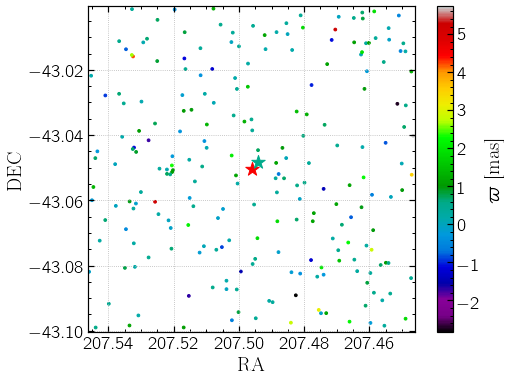

In [32]:
#Plot region around AB:
# Interval size in degrees:
d = 0.05
# Select objects in that interval:
ind = np.where((cone['ra'] < gaiaA['ra'][0]+d) & (cone['ra'] > gaiaA['ra'][0]-d) &
               (cone['dec'] < gaiaA['dec'][0]+d) & (cone['dec'] > gaiaA['dec'][0]-d))
 
import matplotlib
# Color points by parallax:
cmap = 'nipy_spectral'
cmap = matplotlib.cm.get_cmap(cmap)
# Compute the color to assign A and B:
percent = (gaiaA['parallax'] - np.nanmin(cone['parallax'].loc[ind])) / \
    (np.max(cone['parallax'].loc[ind] - np.nanmin(cone['parallax'].loc[ind])))
Acolor = cmap(percent)

percent = (gaiaB['parallax'] - np.nanmin(cone['parallax'].loc[ind])) / \
    (np.max(cone['parallax'].loc[ind] - np.nanmin(cone['parallax'].loc[ind])))
Bcolor = cmap(percent)

%matplotlib inline
plt.style.use('magrathea')
c = plt.scatter(cone['ra'].loc[ind],cone['dec'].loc[ind],ls='None', marker='.', 
                s=30, c=cone['parallax'].loc[ind],cmap=cmap)
plt.scatter(gaiaA['ra'],gaiaA['dec'],marker='*',color=Acolor, zorder=10, s=200)
plt.scatter(gaiaB['ra'],gaiaB['dec'],marker='*',color=Bcolor, zorder=10, s=200)
cbar = plt.colorbar(c)
plt.gca().set_aspect('equal')
plt.grid(ls=':')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.gca().invert_xaxis()
plt.ylim(gaiaA['dec']-d,gaiaA['dec']+d)
plt.xlim(gaiaA['ra']+d,gaiaA['ra']-d)
cbar.set_label(r'$\varpi$ [mas]')
plt.savefig('friends_of_HIPA_parallax.png', dpi=300, bbox_inches='tight')

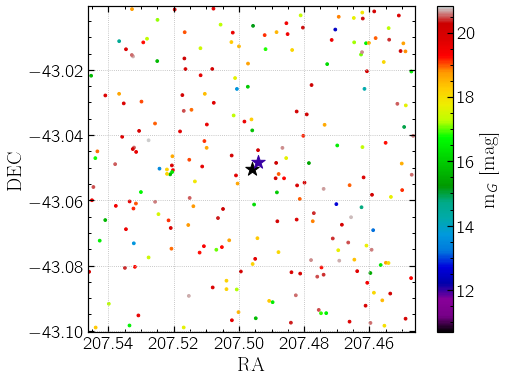

In [33]:
# Same plot colored by G magnitude
d = 0.05
ind = np.where((cone['ra'] < gaiaA['ra'][0]+d) & (cone['ra'] > gaiaA['ra'][0]-d) &
               (cone['dec'] < gaiaA['dec'][0]+d) & (cone['dec'] > gaiaA['dec'][0]-d))
 
import matplotlib
cmap = 'nipy_spectral'
cmap = matplotlib.cm.get_cmap(cmap)
percent = (gaiaA['phot_g_mean_mag'] - np.nanmin(cone['phot_g_mean_mag'].loc[ind])) / \
    (np.max(cone['phot_g_mean_mag'].loc[ind] - np.nanmin(cone['phot_g_mean_mag'].loc[ind])))
#percent = gaiaA['parallax'] / np.max(cone['parallax'].loc[ind])
Acolor = cmap(percent)

percent = (gaiaB['phot_g_mean_mag'] - np.nanmin(cone['phot_g_mean_mag'].loc[ind])) / \
    (np.max(cone['phot_g_mean_mag'].loc[ind] - np.nanmin(cone['phot_g_mean_mag'].loc[ind])))
Bcolor = cmap(percent)


plt.style.use('magrathea')
c = plt.scatter(cone['ra'].loc[ind],cone['dec'].loc[ind],ls='None', marker='.', 
                s=30, c=cone['phot_g_mean_mag'].loc[ind],cmap=cmap)
plt.scatter(gaiaA['ra'],gaiaA['dec'],marker='*',color=Acolor, zorder=10, s=200)
plt.scatter(gaiaB['ra'],gaiaB['dec'],marker='*',color=Bcolor, zorder=10, s=200)
cbar = plt.colorbar(c)
plt.gca().set_aspect('equal')
plt.grid(ls=':')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.gca().invert_xaxis()
plt.ylim(gaiaA['dec']-d,gaiaA['dec']+d)
plt.xlim(gaiaA['ra']+d,gaiaA['ra']-d)
cbar.set_label(r'm$_G$ [mag]')
#plt.savefig('friends_of_HIPA.png', dpi=300, bbox_inches='tight')

### Compute probabilities:

In [34]:
# Compute probability of finding two objects within 9 arcsec given the density of objects within 1 deg of HIP A
# using a Monte Carlo simulation:

# set radius:
import astropy.units as u
radius =(cone['dist'][1] - cone['dist'][0])*u.deg
radius = 9*u.arcsec.to(u.deg)

# How many samples:
n = 1000
# Select a random set of n indicies:
np.random.seed(42)
rand = np.random.choice(range(len(cone)),n, replace=False)
# make a container for results:
n_friends = np.array([])

# for each randomly selected Gaia object:
for i in rand:
    # compute the separation of all other objects in RA and Dec:
    dra = np.abs(cone['ra'] - cone['ra'][i])
    ddec = np.abs(cone['dec'] - cone['dec'][i])
    # compute the separation of all other Gaia objects:
    dists = np.sqrt(dra**2 + ddec**2)
    # Count how many Gaia objects have separation less than 9 arcsec
    # and add it to the results:
    n_friends = np.append(n_friends,np.sum(dists < radius))
    
# Print the fraction of trials that have more than 1 object within 9 arcsec:
print(np.shape(n_friends[np.where(n_friends >= 2.)])[0]/n)

0.381


In [85]:
# Repeat the simulation many times:
prob_of_being_within_9arcsec = np.array([])

def update_progress(n,max_value):
    ''' Create a progress bar
    
    Args:
        n (int): current count
        max_value (int): ultimate values
    
    '''
    import sys
    barLength = 20 # Modify this to change the length of the progress bar
    status = ""
    progress = np.round(float(n/max_value),decimals=2)
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    #if progress >= 1.:
    #    progress = 1
    #    status = "Done...\r\n"
    if n == max_value:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\r{0}% ({1} of {2}): |{3}|  {4}".format(np.round(progress*100,decimals=1), 
                                                  n, 
                                                  max_value, 
                                                  "#"*block + "-"*(barLength-block), 
                                                  status)
    sys.stdout.write(text)
    sys.stdout.flush()
    

for j in range(100):
    rand = np.random.choice(range(len(cone)),n, replace=False)
    n_friends = np.array([])

    for i in rand:
        dra = np.abs(cone['ra'] - cone['ra'][i])
        ddec = np.abs(cone['dec'] - cone['dec'][i])
        dists = np.sqrt(dra**2 + ddec**2)
        n_friends = np.append(n_friends,np.sum(dists < radius))
    prob_of_being_within_9arcsec = np.append(prob_of_being_within_9arcsec,
                                             np.shape(n_friends[np.where(n_friends >= 2.)])[0]/n)
    update_progress(j+1,100)


99.0% (99 of 100): |####################|  

In [87]:
# Print average and stddev number of trials with more than one object from all of our simulations:
print(np.mean(prob_of_being_within_9arcsec),np.std(prob_of_being_within_9arcsec))

(0.38893, 0.016051327047942175)

### Repeat simulation for probability of finding two objects within 9 arcsec and 2 magnitudes:

In [187]:
prob_of_being_within_9arcsec_and2mags = np.array([])


for j in range(100):
    rand = np.random.choice(range(len(cone)),n, replace=False)
    n_friends = np.array([])

    for i in rand:
        dra = np.abs(cone['ra'] - cone['ra'][i])
        ddec = np.abs(cone['dec'] - cone['dec'][i])
        dm = np.abs(cone['phot_g_mean_mag'] - cone['phot_g_mean_mag'][i])
        dists = np.sqrt(dra**2 + ddec**2)
        n_friends = np.append(n_friends,np.sum((dists < radius) & (dm < delta_mag)))
    prob_of_being_within_9arcsec_and2mags = np.append(prob_of_being_within_9arcsec_and2mags,
                                             np.shape(n_friends[np.where(n_friends >= 2.)])[0]/n)
    update_progress(j+1,100)
    
print(np.mean(prob_of_being_within_9arcsec_and2mags),np.std(prob_of_being_within_9arcsec_and2mags))

100% (100 of 100): |####################|  Done...


(0.04531999999999999, 0.0069597126377459)